# Zadania

In [1]:
#! /usr/bin/python
# Two-class MNIST 
from keras.datasets import mnist
import numpy as np

d1 = 5
d2 = 6

(mnist_x_train, mnist_y_train), (mnist_x_test, mnist_y_test) = mnist.load_data()

X_train = (mnist_x_train.astype('float32') / 255.).reshape((len(mnist_x_train), np.prod(mnist_x_train.shape[1:])))
y_train = mnist_y_train
X_test = (mnist_x_test.astype('float32') / 255.).reshape((len(mnist_x_test), np.prod(mnist_x_test.shape[1:])))
y_test = mnist_y_test

X_train = X_train[np.logical_or(y_train == d1, y_train == d2)]
y_train = y_train[np.logical_or(y_train == d1, y_train == d2)]
y_train[y_train==d1] = 0
y_train[y_train==d2] = 1
y_train = y_train.astype('float32')
X_test = X_test[np.logical_or(y_test == d1, y_test == d2)]
y_test = y_test[np.logical_or(y_test == d1, y_test == d2)]
y_test[y_test==d1] = 0
y_test[y_test==d2] = 1
y_test = y_test.astype('float32')

print(X_train.shape)
print(X_test.shape)



Using Theano backend.


(11339, 784)
(1850, 784)


## Ćwiczenie 1 [5 pkt]

Uzupełnij metody forward_pass oraz backward_pass w klasach ReLU, Sigmoid i Dense. Metoda forward_pass ma przyjmować batch inputów i zwracać batch outputów. Metoda backward_pass ma przyjmować batch inputów oraz batch pochodnych cząstkowych outputów i zwracać batch pochodnych cząstkowych inputów oraz wektor (**nie batch**) pochodnych cząstkowych wag. Jeśli wagi przechowujemy w macierzy dwuwymiarowej, to możemy najpierw policzyć pochodne cząstkowe w macierzy o takim samym kształcie, a następnie np. użyć .flat. 

Uwaga: dla warstw bez wag należy zwrócić None.

## Ćwiczenie 2 [4 pkt]

Uzupełnij metodę _forward_pass klasy Network. Metoda ta ma przyjmować batch inputów (X) i zwracać dwie rzeczy:
* inps - lista batchów inputów dla każdej warstwy w sieci (włącznie z X); te wartości będziemy używali w metodzie _backward_pass
* output - batch outputów z sieci (czyli $\mathbf{\hat y}$); output **nie** powinien być ostatnim elementem inps.

## Ćwiczenie 3 [5 pkt]

Uzupełnij metodę _backward_pass klasy Network. Zwróć uwagę, że pochodna funkcji kosztu po neuronach ostatniej warstwy jest już liczona w metodzie _fit_on_batch. Metoda ma zwracać listę layer_grads, której elementy to wektory pochodnych cząstkowych funkcji kosztu po kolejnych warstwach (zwrócone przez metodę Layer.backward_pass). Kolejność wektorów w tej liście ma być zgodna z kolejnością warstw w sieci.

## Ćwiczenie 4 [3 pkt]
Naucz sieć neuronową z jedną warstwą ukrytą i aktywacją Sigmoid na powyższych danych (dwuklasowy MNIST). Użyj MSE jako funkcji kosztu (oznacza to regresję do numeru klasy, co jest złym pomysłem, ale póki nie mamy klasy Crossentropy musi nam to wystarczyć). Użyj GD. Reportuj loss oraz accuracy.

## Ćwiczenie 5 [3 pkt]
Uzupełnić klasę Crossentropy, wzorując się na klasie MSE.

## Ćwiczenie  6 [3 pkt]
Uzupełnić klasę Momentum, wzorując się na klasie GD. Wzory można znaleźć tutaj: http://distill.pub/2017/momentum/

## Ćwiczenie 7 [3 pkt]
Naucz sieć neuronową z jedną warstwą ukrytą. Rozważ dwa przypadki: aktywację ReLU oraz Sigmoid. Czy jest sens używać ReLU jako ostatnią warstwę? Użyj Crossentropy jako funkcji kosztu. Użyj Momentum. Reportuj loss oraz accuracy.

## Ćwiczenie 8 [6 pkt]
Vanishing gradient.

Zadanie polega na zbadaniu zjawiska *vanishing gradient* w głębokich sieciach. Należy zmodyfikować kod warstwy Dense i dodać monitorowanie **normy euklidesowej** wektora delta_weights. Każdą warstwę Dense w trenowanej sieci należy monitorować oddzielnie. Po każdym wywołaniu metody fit_on_batch każdy z monitorów powinien zapamiętać nową normę. Po nauczeniu sieci dla każdej warstwy należy narysować wykres: poziomo - numer wywołania fit_on_batch, pionowo - norma delta_weights. Im niżej znajduje się warstwa Dense, tym silniej będzie zachodziło zjawisko *vanishing gradient*.

Naucz dwuwarstwową sieć z aktywacjami Sigmoid, reportując normy delta_weights. Powtórz to dla głębszej sieci (np. 6-10 warstw).

## Ćwiczenie 9 [4 pkt]
Przetestować kod z ćwiczenia 7. (dwuwarstwowa sieć) stosując inne inicjalizacje wag w warstwach Dense. Napisać własną inicjalizację wag, która sprawi, że sieć niczego się nie nauczy (init='stupid').


In [18]:
def accuracy(pred, t):
    return np.mean(t == np.around(pred))
# Warstwy
class Layer():

    def forward_pass(self, input):
        # return output
        raise NotImplementedError()

    def backward_pass(self, input, output_grad):
        # return input_grad, weight_grad
        raise NotImplementedError()

    def update_weights(self, delta_weights):
        pass

    def debug_grad(self, evaluate_loss):
        return None

class ReLU(Layer):

    def forward_pass(self, input):
        return np.maximum(np.zeros(input.shape),input)
        
    def backward_pass(self, input, output_grad):
        
        #print(input)
        rows, cols = input.shape
        input2 = np.matrix(np.zeros(input.shape))
        for i in range(rows):
            for j in range(cols):
                if(input[i,j]>0):
                    input2[i, j] = 1
                else:
                    input2[i,j]=0
        return np.multiply(output_grad, input2), None
        
        #return None

class Sigmoid(Layer):

    def forward_pass(self, input):
        return 1./(1.+ np.exp(-input))

    def backward_pass(self, input, output_grad):
        return np.multiply(np.multiply(output_grad, self.forward_pass(input)), (np.ones(input.shape) - self.forward_pass(input))), None

class Dense(Layer):

    def __init__(self, input_size, output_size, init = 'gaussian'):
        self.norms = []
        input_size += 1
        if init == 'zeros':
            self.weights = np.zeros((input_size, output_size))
        elif init == 'gaussian':
            self.weights = np.random.normal(
                0.,
                2. / (input_size + output_size),
                (input_size, output_size)
            )
        elif init == 'stupid':
            # Ćwiczenie 8
            self.weights = 3*np.ones((input_size, output_size))          
        else:
            raise NotImplementedError()
        self.weights = np.asmatrix(self.weights)       

    def forward_pass(self, input):
        input2 = np.hstack((np.ones((input.shape[0], 1)), input))
        return np.dot(input2, self.weights)  
    
    def backward_pass(self, input, output_grad):
        input2 = np.hstack((np.ones((input.shape[0],1)),input))     
        weight_grad = np.dot(input2.T, output_grad)
        input_grad = np.dot(output_grad, self.weights.T)
        return input_grad[:,1:], weight_grad.flat[:]

    def update_weights(self, delta_weights):
        # Ćwiczenie 7 - monitorowanie normy wektora delta_weights
        self.weights += delta_weights.reshape(self.weights.shape)
        self.norms.append(np.linalg.norm(delta_weights))

    def debug_grad(self, evaluate_loss):
        base = evaluate_loss()
        grad = []
        for (x, y), w in np.ndenumerate(self.weights):
            self.weights[x, y] = w + 0.0001
            changed = evaluate_loss()
            grad.append(10000. * (changed - base))
            self.weights[x, y] = w
        return grad

      
        
        

In [3]:
# Optimizers

class Optimizer():

    def calculate_deltas(self, grad):
        raise NotImplementedError()

class GD(Optimizer):

    def __init__(self, learning_rate):
        self.learning_rate = learning_rate

    def calculate_deltas(self, grad):
        return -self.learning_rate * grad

class Momentum(Optimizer):

    def __init__(self, alpha, beta):
        self.alpha = alpha
        self.beta = beta
        self.z = 0
        
    def calculate_deltas(self, grad):
        self.z = self.beta * self.z + grad
        return -self.alpha * self.z

In [4]:
# Funkcje kosztu

class Loss():

    def forward_pass(self, y, t):
        # return cost
        raise NotImplementedError()

    def backward_pass(self, y, t):
        # return y_grad
        raise NotImplementedError()

class MSE(Loss):

    def forward_pass(self, y, t):
        return np.average(0.5 * np.square(y - t))

    def backward_pass(self, y, t):
        return (y - t) / y.size

class Crossentropy(Loss):

    def forward_pass(self, y, t):
        # Ćwiczenie 5
        cel1 = np.multiply(-t, np.log(y))
        cel2 = np.multiply(1-t,np.log(1-y))
        return sum(cel1 - cel2)/t.size
        
    def backward_pass(self, y, t):
        # Ćwiczenie 5
        return (-t/y + (1-t)/(1-y))/ y.size


In [5]:
class Network():

    def __init__(self, loss, optimizer, metrics = []):
        self.layers = []
        self.loss = loss
        self.optimizer = optimizer
        self.metrics = metrics

    def add(self, layer):
        self.layers.append(layer)

    def fit(self, X, t, epochs, batch_size=256, print_stats=False):
        X = np.array(X)
        t = np.array(t)
        X = X.reshape(len(X), -1)
        t = t.reshape(len(t), -1)
        if X.shape[0] != t.shape[0]:
            raise ValueError("Array sizes don't match")

        for epoch in range(epochs):
            if print_stats:
                print("Epoch %d" % (epoch+1))
                print("    -> batch size: %d" % batch_size)
            rng_state = np.random.get_state()
            np.random.shuffle(X)
            np.random.set_state(rng_state)
            np.random.shuffle(t)
            pos = 0
            while pos < len(X):
                batch_X = X[pos:pos+batch_size]
                batch_t = t[pos:pos+batch_size]
                self._fit_on_batch(batch_X, batch_t)
                pos += batch_size
            if print_stats:
                _, y = self._forward_pass(X)
                l = self.loss.forward_pass(y, t)
                print("    -> loss: %f" % l)
                for m in self.metrics:
                    print("    -> %s: %f" % (m.__name__, m(y, t)))

    def predict(self, X):
        inps, out = self._forward_pass(X)
        return out

    def _fit_on_batch(self, batch_X, batch_t):
        inps, out = self._forward_pass(batch_X)
        layer_grads = self._backward_pass(
            inps,
            self.loss.backward_pass(out, batch_t)
        )
        grad = self._join(layer_grads)
        deltas = self.optimizer.calculate_deltas(grad)
        for l, d in zip(self.layers, self._split(deltas, layer_grads)):
            if not d is None:
                l.update_weights(d)

    def _join(self, grads):
        return np.concatenate([g for g in grads if not g is None])

    def _split(self, grads, layer_grads):
        out = []
        start = 0
        for l in layer_grads:
            if l is None:
                out.append(None)
            else:
                out.append(grads[start:start+len(l)])
                start += len(l)
        return out

    def _forward_pass(self, X):
        inps = []
        output = None
        #print(X)
        inps.append(X)
        for i in range(len(self.layers)-1):
            inps.append(self.layers[i].forward_pass(inps[-1]))
        output = self.layers[-1].forward_pass(inps[-1])

        # Ćwiczenie 2
        
        return inps, output

    def _backward_pass(self, inps, grad):
        layer_grads = []
        out = grad
        for i in range(len(self.layers)):
                out, grad = self.layers[-i-1].backward_pass(inps[-i-1], out)
                layer_grads.append(grad)
                    

        # Ćwiczenie 3
        layer_grads.reverse()
        return layer_grads

    def _debug_grads(self, X, t):
        layer_grads = []
        for l in self.layers:
            g = l.debug_grad(
                lambda: self.loss.forward_pass(self._forward_pass(X)[1], t)
            )
            if not g is None:
                g = np.array(np.array(g).flat)
            layer_grads.append(g)
        return layer_grads

In [6]:
# Ćwiczenie 4
def accurancy_score(y, t):
    accur = np.mean(t == np.around(y))
    return accur
my_network = Network(loss=MSE(), optimizer=GD(learning_rate=0.01), metrics=[accurancy_score])
my_network.add(Dense(input_size=X_train.shape[1], output_size=1, init="gaussian"))
my_network.fit(X_train, y_train, 10, print_stats=True)




Epoch 1
    -> batch size: 256
    -> loss: 0.030156
    -> accurancy_score: 0.952818
Epoch 2
    -> batch size: 256
    -> loss: 0.027373
    -> accurancy_score: 0.961637
Epoch 3
    -> batch size: 256
    -> loss: 0.026230
    -> accurancy_score: 0.964724
Epoch 4
    -> batch size: 256
    -> loss: 0.025499
    -> accurancy_score: 0.965782
Epoch 5
    -> batch size: 256
    -> loss: 0.025002
    -> accurancy_score: 0.966928
Epoch 6
    -> batch size: 256
    -> loss: 0.024623
    -> accurancy_score: 0.967722
Epoch 7
    -> batch size: 256
    -> loss: 0.024105
    -> accurancy_score: 0.968604
Epoch 8
    -> batch size: 256
    -> loss: 0.023920
    -> accurancy_score: 0.969309
Epoch 9
    -> batch size: 256
    -> loss: 0.023447
    -> accurancy_score: 0.970103
Epoch 10
    -> batch size: 256
    -> loss: 0.023216
    -> accurancy_score: 0.970456


In [9]:
# Ćwiczenie 7

my_network2 = Network(Crossentropy(), Momentum(alpha = 0.01, beta = 0.2), metrics = [accurancy_score])
my_network2.add(Dense(input_size=X_train.shape[1], output_size = 1))
my_network2.add(Sigmoid())

my_network2.fit(X_train, y_train, 10, print_stats=True)

my_network3 = Network(Crossentropy(), Momentum(alpha = 0.01, beta = 0.2), metrics = [accurancy_score])
my_network3.add(Dense(input_size=X_train.shape[1], output_size = 1))
my_network3.add(ReLU())

my_network3.fit(X_train, y_train, 10, print_stats=True)

# Nie ma sensu używania ReLU jako ostatniej warstwy, 
# bo tracimy wyniki z ujemnych liczb które funkcja zamienia na zera.




Epoch 1
    -> batch size: 256
    -> loss: 0.368928
    -> accurancy_score: 0.944351
Epoch 2
    -> batch size: 256
    -> loss: 0.273211
    -> accurancy_score: 0.951671
Epoch 3
    -> batch size: 256
    -> loss: 0.227512
    -> accurancy_score: 0.956875
Epoch 4
    -> batch size: 256
    -> loss: 0.200247
    -> accurancy_score: 0.958727
Epoch 5
    -> batch size: 256
    -> loss: 0.181907
    -> accurancy_score: 0.960402
Epoch 6
    -> batch size: 256
    -> loss: 0.168505
    -> accurancy_score: 0.962519
Epoch 7
    -> batch size: 256
    -> loss: 0.158275
    -> accurancy_score: 0.963312
Epoch 8
    -> batch size: 256
    -> loss: 0.150191
    -> accurancy_score: 0.964018
Epoch 9
    -> batch size: 256
    -> loss: 0.143563
    -> accurancy_score: 0.964812
Epoch 10
    -> batch size: 256
    -> loss: 0.138012
    -> accurancy_score: 0.965341
Epoch 1
    -> batch size: 256
    -> loss: nan
    -> accurancy_score: 0.000000
Epoch 2
    -> batch size: 256
    -> loss: nan
    -> acc

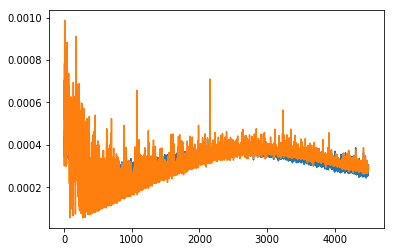

1  i 2 warstwa


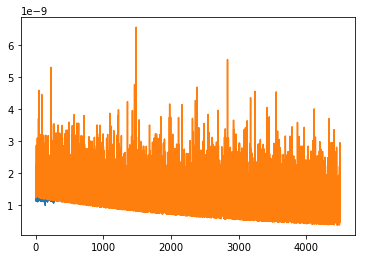

In [8]:
from matplotlib import pyplot as plt

# Ćwiczenie 8
my_network8 = Network(loss=MSE(), optimizer=GD(learning_rate=0.01), metrics=[accurancy_score])
my_network8.add(Dense(input_size=X_train.shape[1], output_size = 10))
my_network8.add(Sigmoid())
my_network8.add(Dense(input_size=10, output_size = 1))
my_network8.add(Sigmoid())

my_network8.fit(X_train, y_train, 100)

plt.plot(my_network8.layers[0].norms)
plt.plot(my_network8.layers[2].norms)
plt.show()


my_network82 = Network(loss=MSE(), optimizer=GD(learning_rate=0.01), metrics=[accurancy_score])
my_network82.add(Dense(input_size=X_train.shape[1], output_size = 10))
my_network82.add(Sigmoid())
my_network82.add(Dense(input_size=10, output_size = 10))
my_network82.add(Sigmoid())
my_network82.add(Dense(input_size=10, output_size = 10))
my_network82.add(Sigmoid())
my_network82.add(Dense(input_size=10, output_size = 10))
my_network82.add(Sigmoid())
my_network82.add(Dense(input_size=10, output_size = 10))
my_network82.add(Sigmoid())
my_network82.add(Dense(input_size=10, output_size = 10))
my_network82.add(Sigmoid())



my_network82.fit(X_train, y_train, 100)
print("1  i 2 warstwa")
plt.plot(my_network82.layers[0].norms)
plt.plot(my_network82.layers[2].norms)
plt.show()


3 i 4 warstwa


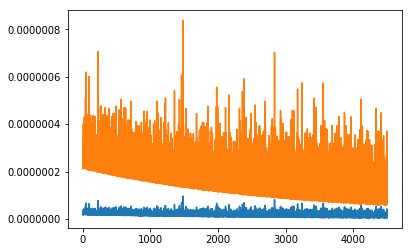

In [10]:
print("3 i 4 warstwa")
plt.plot(my_network82.layers[4].norms)
plt.plot(my_network82.layers[6].norms)
plt.show()

5 i 6 warstwa


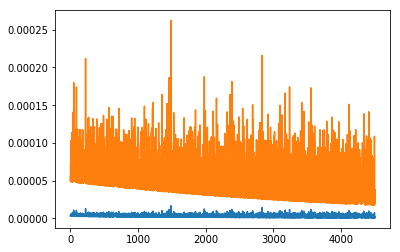

In [11]:
print("5 i 6 warstwa")
plt.plot(my_network82.layers[8].norms)
plt.plot(my_network82.layers[10].norms)
plt.show()

In [12]:
# Ćwiczenie 9

my_network9 = Network(loss=MSE(), optimizer=GD(learning_rate=0.01), metrics=[accurancy_score])
my_network9.add(Dense(input_size=X_train.shape[1], output_size=1, init="stupid"))
my_network9.add(Sigmoid())
my_network9.fit(X_train, y_train, 10, print_stats=True)



Epoch 1
    -> batch size: 256
    -> loss: 0.239042
    -> accurancy_score: 0.521916
Epoch 2
    -> batch size: 256
    -> loss: 0.239042
    -> accurancy_score: 0.521916
Epoch 3
    -> batch size: 256
    -> loss: 0.239042
    -> accurancy_score: 0.521916
Epoch 4
    -> batch size: 256
    -> loss: 0.239042
    -> accurancy_score: 0.521916
Epoch 5
    -> batch size: 256
    -> loss: 0.239042
    -> accurancy_score: 0.521916
Epoch 6
    -> batch size: 256
    -> loss: 0.239042
    -> accurancy_score: 0.521916
Epoch 7
    -> batch size: 256
    -> loss: 0.239042
    -> accurancy_score: 0.521916
Epoch 8
    -> batch size: 256
    -> loss: 0.239042
    -> accurancy_score: 0.521916
Epoch 9
    -> batch size: 256
    -> loss: 0.239042
    -> accurancy_score: 0.521916
Epoch 10
    -> batch size: 256
    -> loss: 0.239042
    -> accurancy_score: 0.521916


# Asserty

## Ćwiczenie 1

In [19]:
np.random.seed(43)
d1 = Dense(input_size=4, output_size=3, init="gaussian")
d2 = Dense(input_size=4, output_size=3, init="zeros")
r = ReLU()
s = Sigmoid()
inp = np.random.random(4).reshape((1,-1)) - 0.5
out_grad_4 = np.random.random(4).reshape((1,-1)) - 0.5
out_grad_3 = np.random.random(3).reshape((1,-1)) - 0.5

print("inp:")
print(inp.shape)
print(inp)
print("out_grad_4:")
print(out_grad_4.shape)
print(out_grad_4)
print("out_grad_3:")
print(out_grad_3.shape)
print(out_grad_3)

print("Testing d1...")
print("d1.forward_pass(inp):")
t = d1.forward_pass(inp)
print(t.shape)
print(t)
print("d1.backward_pass(inp, out_grad_3):")
t = d1.backward_pass(inp, out_grad_3)
print(t[0].shape)
print(t[0])
print(t[1].shape)
print(t[1])

print("Testing d2...")
print("d2.forward_pass(inp):")
t = d2.forward_pass(inp)
print(t.shape)
print(t)
print("d2.backward_pass(inp, out_grad_3):")
t = d2.backward_pass(inp, out_grad_3)
print(t[0].shape)
print(t[0])
print(t[1].shape)
print(t[1])

print("Testing r...")
print("r.forward_pass(inp):")
t = r.forward_pass(inp)
print(t.shape)
print(t)
print("r.backward_pass(inp, out_grad_4):")
t = r.backward_pass(inp, out_grad_4)
print(t[0].shape)
print(t[0])
print(t[1])

print("Testing s...")
print("s.forward_pass(inp):")
t = s.forward_pass(inp)
print(t.shape)
print(t)
print("s.backward_pass(inp, out_grad_4):")
t = s.backward_pass(inp, out_grad_4)
print(t[0].shape)
print(t[0])
print(t[1])






inp:
(1, 4)
[[-0.05424164  0.16972465 -0.41749995  0.39709858]]
out_grad_4:
(1, 4)
[[-0.2019965  -0.23769518 -0.49487045  0.04320252]]
out_grad_3:
(1, 3)
[[-0.02440363  0.13637368  0.47820413]]
Testing d1...
d1.forward_pass(inp):
(1, 3)
[[-0.02707048 -0.20288487 -0.03403094]]
d1.backward_pass(inp, out_grad_3):
(1, 4)
[[-0.01685764  0.21647157  0.04530229  0.03971692]]
(15,)
[-0.02440363  0.13637368  0.47820413  0.00132369 -0.00739713 -0.02593858
 -0.0041419   0.02314597  0.08116303  0.01018852 -0.056936   -0.1996502
 -0.00969065  0.05415379  0.18989418]
Testing d2...
d2.forward_pass(inp):
(1, 3)
[[ 0.  0.  0.]]
d2.backward_pass(inp, out_grad_3):
(1, 4)
[[ 0.  0.  0.  0.]]
(15,)
[-0.02440363  0.13637368  0.47820413  0.00132369 -0.00739713 -0.02593858
 -0.0041419   0.02314597  0.08116303  0.01018852 -0.056936   -0.1996502
 -0.00969065  0.05415379  0.18989418]
Testing r...
r.forward_pass(inp):
(1, 4)
[[ 0.          0.16972465  0.          0.39709858]]
r.backward_pass(inp, out_grad_4):
(1,

    inp:
    (1, 4)
    [[-0.05424164  0.16972465 -0.41749995  0.39709858]]
    out_grad_4:
    (1, 4)
    [[-0.2019965  -0.23769518 -0.49487045  0.04320252]]
    out_grad_3:
    (1, 3)
    [[-0.02440363  0.13637368  0.47820413]]
    Testing d1...
    d1.forward_pass(inp):
    (1, 3)
    [[-0.02707048 -0.20288487 -0.03403094]]
    d1.backward_pass(inp, out_grad_3):
    (1, 4)
    [[-0.01685764  0.21647157  0.04530229  0.03971692]]
    (15,)
    [-0.02440363  0.13637368  0.47820413  0.00132369 -0.00739713 -0.02593858
     -0.0041419   0.02314597  0.08116303  0.01018852 -0.056936   -0.1996502
     -0.00969065  0.05415379  0.18989418]
    Testing d2...
    d2.forward_pass(inp):
    (1, 3)
    [[ 0.  0.  0.]]
    d2.backward_pass(inp, out_grad_3):
    (1, 4)
    [[ 0.  0.  0.  0.]]
    (15,)
    [-0.02440363  0.13637368  0.47820413  0.00132369 -0.00739713 -0.02593858
     -0.0041419   0.02314597  0.08116303  0.01018852 -0.056936   -0.1996502
     -0.00969065  0.05415379  0.18989418]
    Testing r...
    r.forward_pass(inp):
    (1, 4)
    [[ 0.          0.16972465  0.          0.39709858]]
    r.backward_pass(inp, out_grad_4):
    (1, 4)
    [[ 0.         -0.23769518  0.          0.04320252]]
    None
    Testing s...
    s.forward_pass(inp):
    (1, 4)
    [[ 0.48644291  0.5423296   0.39711514  0.59799036]]
    s.backward_pass(inp, out_grad_4):
    (1, 4)
    [[-0.050462   -0.05899789 -0.11847926  0.01038579]]
    None

## Ćwiczenie 2

In [14]:
np.random.seed(43)
n = Network(loss=MSE(), optimizer=GD(learning_rate=0.001), metrics=[])
n.add(Dense(input_size=4, output_size=3, init="gaussian"))
n.add(ReLU())
n.add(Dense(input_size=3, output_size=4, init="gaussian"))
n.add(ReLU())
n.add(Dense(input_size=4, output_size=1, init="gaussian"))
n.add(Sigmoid())
inp = np.random.random((2,4)) - 0.5
inps, out = n._forward_pass(inp)

print("inp:")
print(inp)
for i, inp in enumerate(inps):
    print("inps[" + str(i) + "]:")
    print(inp)
print("out:")
print(out)

inp:
[[ 0.06066317 -0.08874451  0.22698799 -0.10080311]
 [ 0.17014516  0.20471561  0.10955987  0.04003446]]
inps[0]:
[[ 0.06066317 -0.08874451  0.22698799 -0.10080311]
 [ 0.17014516  0.20471561  0.10955987  0.04003446]]
inps[1]:
[[ 0.06231216 -0.25663962 -0.11549112]
 [ 0.03836232 -0.10585852 -0.03015728]]
inps[2]:
[[ 0.06231216  0.          0.        ]
 [ 0.03836232  0.          0.        ]]
inps[3]:
[[-0.04493685  0.4840028  -0.15711608 -0.22696511]
 [-0.0396103   0.48391873 -0.15615311 -0.24031931]]
inps[4]:
[[ 0.          0.4840028   0.          0.        ]
 [ 0.          0.48391873  0.          0.        ]]
inps[5]:
[[ 0.29948146]
 [ 0.29947621]]
out:
[[ 0.57431575]
 [ 0.57431447]]


    inp:
    [[ 0.06066317 -0.08874451  0.22698799 -0.10080311]
     [ 0.17014516  0.20471561  0.10955987  0.04003446]]
    inps[0]:
    [[ 0.06066317 -0.08874451  0.22698799 -0.10080311]
     [ 0.17014516  0.20471561  0.10955987  0.04003446]]
    inps[1]:
    [[ 0.06231216 -0.25663962 -0.11549112]
     [ 0.03836232 -0.10585852 -0.03015728]]
    inps[2]:
    [[ 0.06231216  0.          0.        ]
     [ 0.03836232  0.          0.        ]]
    inps[3]:
    [[-0.04493685  0.4840028  -0.15711608 -0.22696511]
     [-0.0396103   0.48391873 -0.15615311 -0.24031931]]
    inps[4]:
    [[ 0.          0.4840028   0.          0.        ]
     [ 0.          0.48391873  0.          0.        ]]
    inps[5]:
    [[ 0.29948146]
     [ 0.29947621]]
    out:
    [[ 0.57431575]
     [ 0.57431447]]

## Ćwiczenie 3

In [15]:
np.random.seed(43)
n = Network(loss=MSE(), optimizer=GD(learning_rate=0.001), metrics=[])
n.add(Dense(input_size=4, output_size=3, init="gaussian"))
n.add(ReLU())
n.add(Dense(input_size=3, output_size=4, init="gaussian"))
n.add(ReLU())
n.add(Dense(input_size=4, output_size=1, init="gaussian"))
n.add(Sigmoid())

inp = np.random.random((2,4)) - 0.5
target = inp[:,0:1]
inps, out = n._forward_pass(inp)
grad = n.loss.backward_pass(out, target)
layer_grads = n._backward_pass(inps, grad)

print("inp:")
print(inp)
print("target:")
print(target)
for i, inp in enumerate(inps):
    print("inps[" + str(i) + "]:")
    print(inp)
print("out:")
print(out)
print("grad:")
print(grad)
for i, grad in enumerate(layer_grads):
    print("layer_grads[" + str(i) + "]:")
    print(grad)

inp:
[[ 0.06066317 -0.08874451  0.22698799 -0.10080311]
 [ 0.17014516  0.20471561  0.10955987  0.04003446]]
target:
[[ 0.06066317]
 [ 0.17014516]]
inps[0]:
[[ 0.06066317 -0.08874451  0.22698799 -0.10080311]
 [ 0.17014516  0.20471561  0.10955987  0.04003446]]
inps[1]:
[[ 0.06231216 -0.25663962 -0.11549112]
 [ 0.03836232 -0.10585852 -0.03015728]]
inps[2]:
[[ 0.06231216  0.          0.        ]
 [ 0.03836232  0.          0.        ]]
inps[3]:
[[-0.04493685  0.4840028  -0.15711608 -0.22696511]
 [-0.0396103   0.48391873 -0.15615311 -0.24031931]]
inps[4]:
[[ 0.          0.4840028   0.          0.        ]
 [ 0.          0.48391873  0.          0.        ]]
inps[5]:
[[ 0.29948146]
 [ 0.29947621]]
out:
[[ 0.57431575]
 [ 0.57431447]]
grad:
[[ 0.25682629]
 [ 0.20208465]]
layer_grads[0]:
layer_grads[1]:
None
layer_grads[2]:
layer_grads[3]:
None
layer_grads[4]:
layer_grads[5]:
None


    inp:
    [[ 0.06066317 -0.08874451  0.22698799 -0.10080311]
     [ 0.17014516  0.20471561  0.10955987  0.04003446]]
    target:
    [[ 0.06066317]
     [ 0.17014516]]
    inps[0]:
    [[ 0.06066317 -0.08874451  0.22698799 -0.10080311]
     [ 0.17014516  0.20471561  0.10955987  0.04003446]]
    inps[1]:
    [[ 0.06231216 -0.25663962 -0.11549112]
     [ 0.03836232 -0.10585852 -0.03015728]]
    inps[2]:
    [[ 0.06231216  0.          0.        ]
     [ 0.03836232  0.          0.        ]]
    inps[3]:
    [[-0.04493685  0.4840028  -0.15711608 -0.22696511]
     [-0.0396103   0.48391873 -0.15615311 -0.24031931]]
    inps[4]:
    [[ 0.          0.4840028   0.          0.        ]
     [ 0.          0.48391873  0.          0.        ]]
    inps[5]:
    [[ 0.29948146]
     [ 0.29947621]]
    out:
    [[ 0.57431575]
     [ 0.57431447]]
    grad:
    [[ 0.25682629]
     [ 0.20208465]]
    layer_grads[0]:
    [  2.45711515e-05   0.00000000e+00   0.00000000e+00   2.67516826e-06
       0.00000000e+00   0.00000000e+00   9.94708194e-07   0.00000000e+00
       0.00000000e+00   4.30677425e-06   0.00000000e+00   0.00000000e+00
      -9.52974216e-07   0.00000000e+00   0.00000000e+00]
    layer_grads[1]:
    None
    layer_grads[2]:
    [ 0.          0.00700006  0.          0.          0.          0.00036236
      0.          0.          0.          0.          0.          0.          0.
      0.          0.          0.        ]
    layer_grads[3]:
    None
    layer_grads[4]:
    [ 0.11219329  0.          0.05429771  0.          0.        ]
    layer_grads[5]:
    None

## Ćwiczenie 5

In [16]:
np.random.seed(43)
ce = Crossentropy()
y = np.random.random(10)
t = np.random.random(10)

print("y:")
print(y)
print("t:")
print(t)
print("ce.forward_pass(y,t):")
print(ce.forward_pass(y,t))
print("ce.backward_pass(y,t):")
print(ce.backward_pass(y,t))

y:
[ 0.11505457  0.60906654  0.13339096  0.24058962  0.32713906  0.85913749
  0.66609021  0.54116221  0.02901382  0.7337483 ]
t:
[ 0.39495002  0.80204712  0.25442113  0.05688494  0.86664864  0.221029
  0.40498945  0.31609647  0.0766627   0.84322469]
ce.forward_pass(y,t):
0.736415962327
ce.backward_pass(y,t):
[-0.27490047 -0.08104869 -0.10469935  0.10054647 -0.24509895  0.5272741
  0.11739401  0.0906406  -0.16913545 -0.05603779]


    y:
    [ 0.11505457  0.60906654  0.13339096  0.24058962  0.32713906  0.85913749
      0.66609021  0.54116221  0.02901382  0.7337483 ]
    t:
    [ 0.39495002  0.80204712  0.25442113  0.05688494  0.86664864  0.221029
      0.40498945  0.31609647  0.0766627   0.84322469]
    ce.forward_pass(y,t):
    0.736415962327
    ce.backward_pass(y,t):
    [-0.27490047 -0.08104869 -0.10469935  0.10054647 -0.24509895  0.5272741
      0.11739401  0.0906406  -0.16913545 -0.05603779]

## Ćwiczenie 6

In [17]:
np.random.seed(43)
opt = Momentum(alpha=0.02, beta=0.99)
grad1 = np.random.random(5)
grad2 = np.random.random(5)
grad3 = np.random.random(5)
opt.calculate_deltas(grad1)
opt.calculate_deltas(grad2)
opt.calculate_deltas(grad3)

print("grad1:")
print(grad1)
print("grad2:")
print(grad2)
print("grad3:")
print(grad3)

print("opt.calculate_deltas(grad1):")
print(opt.calculate_deltas(grad1))
print("opt.calculate_deltas(grad2):")
print(opt.calculate_deltas(grad2))
print("opt.calculate_deltas(grad3):")
print(opt.calculate_deltas(grad3))

grad1:
[ 0.11505457  0.60906654  0.13339096  0.24058962  0.32713906]
grad2:
[ 0.85913749  0.66609021  0.54116221  0.02901382  0.7337483 ]
grad3:
[ 0.39495002  0.80204712  0.25442113  0.05688494  0.86664864]
opt.calculate_deltas(grad1):
[-0.02919466 -0.0529381  -0.0209018  -0.01117572 -0.04443381]
opt.calculate_deltas(grad2):
[-0.04608546 -0.06573052 -0.03151603 -0.01164424 -0.05866444]
opt.calculate_deltas(grad3):
[-0.05352361 -0.08111416 -0.03628929 -0.0126655  -0.07541077]


    grad1:
    [ 0.11505457  0.60906654  0.13339096  0.24058962  0.32713906]
    grad2:
    [ 0.85913749  0.66609021  0.54116221  0.02901382  0.7337483 ]
    grad3:
    [ 0.39495002  0.80204712  0.25442113  0.05688494  0.86664864]
    opt.calculate_deltas(grad1):
    [-0.02919466 -0.0529381  -0.0209018  -0.01117572 -0.04443381]
    opt.calculate_deltas(grad2):
    [-0.04608546 -0.06573052 -0.03151603 -0.01164424 -0.05866444]
    opt.calculate_deltas(grad3):
    [-0.05352361 -0.08111416 -0.03628929 -0.0126655  -0.07541077]